In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sb
%matplotlib inline
import main_v2
from main_v2 import generate_dataframe_from_csv_horizontal, generate_dataframe_from_csv_vertical, build_cnn_layer, build_sequential_layer, create_multi_generator
from data_generator_from_kaggle import MultiGenerator
import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Add, Concatenate, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.model_selection import train_test_split
import os
from datetime import datetime
import tensorflow as tf
from math import ceil
import cv2

Using TensorFlow backend.


In [2]:
#main_v2.build_cell_multi_model("saved_models\cell_model.h5")

(512, 512, 3)
[39 39 39]


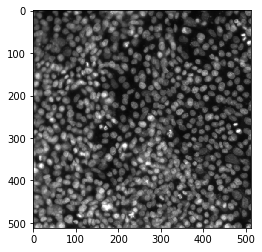

In [16]:
img = cv2.imread("./train/HEPG2-01/Plate1/B02_s1_w1.png")
print(img.shape)
plt.imshow(img)
print(img[0][0])

In [2]:
#df.to_csv(path_or_buf="train_1.csv", index=False)
# df3 = generate_dataframe_from_csv_rootpath("./train.csv")
# df3.to_csv(path_or_buf="train_root.csv", index=False)
# df4 = generate_dataframe_from_csv_horizontal("./train.csv", 6)
# df4.to_csv(path_or_buf="train_6.csv", index=False)
# df3 = pd.read_csv("train_root.csv", dtype={'sirna': object})
# df4 = pd.read_csv("train_6.csv", dtype={'sirna': object})
df_controls = generate_dataframe_from_csv_horizontal("./train_controls.csv", 6, root_name_only=True)
df_controls["cell_type"] = df_controls["experiment"].apply(lambda r: r[:r.find("-")])
# pd.read_csv("train_controls.csv", dtype={'sirna': object})
# display(df4)
# x = df3["img_path_root"]
# y = df3["sirna"]

In [13]:
# df3["cell_type"] = df3["experiment"].apply(lambda r: r[:r.find("-")])
# df4["cell_type"].unique()
# df3.to_csv("train_root.csv")
# df_controls["sirna"] = df_controls["sirna"].apply(lambda r: int(r) - 1108)
print(len(df_controls.sirna.unique()))
display(df_controls)

df_controls.to_csv("./train_controls_root.csv")
# y2 = df3["cell_type"]

31


,id_code,experiment,plate,well,sirna,well_type,img_path_root,cell_type
0,HEPG2-01_1_B02,HEPG2-01,1,B02,30,negative_control,train/HEPG2-01/Plate1/B02_s1,HEPG2
1,HEPG2-01_1_B02,HEPG2-01,1,B02,30,negative_control,train/HEPG2-01/Plate1/B02_s2,HEPG2
2,HEPG2-01_1_C03,HEPG2-01,1,C03,1,positive_control,train/HEPG2-01/Plate1/C03_s1,HEPG2
3,HEPG2-01_1_C03,HEPG2-01,1,C03,1,positive_control,train/HEPG2-01/Plate1/C03_s2,HEPG2
4,HEPG2-01_1_C07,HEPG2-01,1,C07,13,positive_control,train/HEPG2-01/Plate1/C07_s1,HEPG2
5,HEPG2-01_1_C07,HEPG2-01,1,C07,13,positive_control,train/HEPG2-01/Plate1/C07_s2,HEPG2
6,HEPG2-01_1_C11,HEPG2-01,1,C11,18,positive_control,train/HEPG2-01/Plate1/C11_s1,HEPG2
7,HEPG2-01_1_C11,HEPG2-01,1,C11,18,positive_control,train/HEPG2-01/Plate1/C11_s2,HEPG2
8,HEPG2-01_1_C15,HEPG2-01,1,C15,10,positive_control,train/HEPG2-01/Plate1/C15_s1,HEPG2
9,HEPG2-01_1_C15,HEPG2-01,1,C15,10,positive_control,train/HEPG2-01/Plate1/C15_s2,HEPG2


In [10]:
dummies = pd.get_dummies(df_controls.well_type)
print(dummies)
# d = dummies[0:8]
# print(d, d.shape)
# d2 = d.transpose()
# print(d2, d2.shape)

      negative_control  positive_control
0                    1                 0
1                    1                 0
2                    0                 1
3                    0                 1
4                    0                 1
...                ...               ...
8189                 0                 1
8190                 0                 1
8191                 0                 1
8192                 0                 1
8193                 0                 1

[8194 rows x 2 columns]


In [3]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2, stratify=y, random_state=10)

In [4]:
# display(train_csv)
# train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15, stratify=y, random_state=10)

train_generator = MultiGenerator(train_x, train_y, 32, is_train=True)
valid_generator = MultiGenerator(valid_x, valid_y, 32)
#print(generator.__len__(), len(df3))
# imgs, ys = train_generator.__getitem__(1)
# # train_generator.__len__()
# print(len(imgs))
# print(imgs[0].shape)
# keras.utils.to_categorical(ys, 1108).shape

In [2]:
cnn_layers = []
for i in range(0, 6):
    layer = build_cnn_layer(i)
    cnn_layers.append(layer)

output_layer = build_sequential_layer(cnn_layers)

model = Model(inputs=[x.input for x in cnn_layers], outputs=output_layer)
optimizer = optimizers.Adam()    
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputlayer_0 (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
inputlayer_1 (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
inputlayer_2 (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
inputlayer_3 (InputLayer)       (None, 224, 224, 3)  0                                            
_____________________________________

In [6]:
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)

csv_logger = CSVLogger(filename='./training_log.csv',
                       separator=',',
                       append=True)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', verbose=1, save_best_only=True)

callbacks = [checkpointer, reduceLROnPlat, early, csv_logger, tensorboard_callback]
keras.backend.get_session().run(tf.global_variables_initializer())

model.fit_generator(train_generator, 
        steps_per_epoch=train_generator.__len__(),
        validation_data=valid_generator,
        validation_steps=valid_generator.__len__(), 
        epochs=20, verbose=1)

NameError: name 'os' is not defined

In [2]:
train_csv = pd.read_csv("./train.csv")

In [19]:
display(df3["img_path_root"])

0        train/HEPG2-01/Plate1/B03_s1
1        train/HEPG2-01/Plate1/B03_s2
2        train/HEPG2-01/Plate1/B04_s1
3        train/HEPG2-01/Plate1/B04_s2
4        train/HEPG2-01/Plate1/B05_s1
                     ...             
73025     train/U2OS-03/Plate4/O21_s2
73026     train/U2OS-03/Plate4/O22_s1
73027     train/U2OS-03/Plate4/O22_s2
73028     train/U2OS-03/Plate4/O23_s1
73029     train/U2OS-03/Plate4/O23_s2
Name: img_path_root, Length: 73030, dtype: object

In [42]:
samples = df3["img_path_root"][:3]
display(samples)
batches = []

for sample in samples:
    print(sample)
    imgs = []
    for i in range(1, 7):
        imgs.append(f"{sample}_w{i}.png")
    batches.append(imgs)

display(batches)
b = np.transpose(batches)
display(len(b))

0    train/HEPG2-01/Plate1/B03_s1
1    train/HEPG2-01/Plate1/B03_s2
2    train/HEPG2-01/Plate1/B04_s1
Name: img_path_root, dtype: object

train/HEPG2-01/Plate1/B03_s1
train/HEPG2-01/Plate1/B03_s2
train/HEPG2-01/Plate1/B04_s1


[['train/HEPG2-01/Plate1/B03_s1_w1.png',
  'train/HEPG2-01/Plate1/B03_s1_w2.png',
  'train/HEPG2-01/Plate1/B03_s1_w3.png',
  'train/HEPG2-01/Plate1/B03_s1_w4.png',
  'train/HEPG2-01/Plate1/B03_s1_w5.png',
  'train/HEPG2-01/Plate1/B03_s1_w6.png'],
 ['train/HEPG2-01/Plate1/B03_s2_w1.png',
  'train/HEPG2-01/Plate1/B03_s2_w2.png',
  'train/HEPG2-01/Plate1/B03_s2_w3.png',
  'train/HEPG2-01/Plate1/B03_s2_w4.png',
  'train/HEPG2-01/Plate1/B03_s2_w5.png',
  'train/HEPG2-01/Plate1/B03_s2_w6.png'],
 ['train/HEPG2-01/Plate1/B04_s1_w1.png',
  'train/HEPG2-01/Plate1/B04_s1_w2.png',
  'train/HEPG2-01/Plate1/B04_s1_w3.png',
  'train/HEPG2-01/Plate1/B04_s1_w4.png',
  'train/HEPG2-01/Plate1/B04_s1_w5.png',
  'train/HEPG2-01/Plate1/B04_s1_w6.png']]

6

In [27]:
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=.25)
# train_generator2 = create_multi_generator(df4, train_datagen, "training") 
# valid_generator2 = create_multi_generator(df4, train_datagen, "validation") 

In [21]:
# df2 = pd.read_csv("./train_1.csv")
# display(df2)

In [9]:
x = df2["img_path"]
y = df2["sirna"]

In [11]:
from sklearn.utils import class_weight, shuffle
x, y = shuffle(x,y, random_state=10)

In [14]:
x.shape

(73030,)

In [46]:
plate_groups = np.zeros((1108,4), int)
for sirna in range(1108):
    grp = train_csv.loc[train_csv.sirna==sirna,:].plate.value_counts().index.values
#     print(grp)
    assert len(grp) == 3
    plate_groups[sirna,0:3] = grp
    plate_groups[sirna,3] = 10 - grp.sum()
    
plate_groups[:10,:]

array([[4, 2, 3, 1],
       [1, 3, 4, 2],
       [2, 4, 1, 3],
       [1, 3, 4, 2],
       [3, 1, 2, 4],
       [1, 3, 4, 2],
       [1, 3, 4, 2],
       [2, 4, 1, 3],
       [1, 3, 4, 2],
       [4, 2, 3, 1]])

In [44]:
train_csv.loc[train_csv.sirna==1].plate.value_counts().index.values

array([1, 3, 4], dtype=int64)

In [47]:
train_csv.experiment.unique()

array(['HEPG2-01', 'HEPG2-02', 'HEPG2-03', 'HEPG2-04', 'HEPG2-05',
       'HEPG2-06', 'HEPG2-07', 'HUVEC-01', 'HUVEC-02', 'HUVEC-03',
       'HUVEC-04', 'HUVEC-05', 'HUVEC-06', 'HUVEC-07', 'HUVEC-08',
       'HUVEC-09', 'HUVEC-10', 'HUVEC-11', 'HUVEC-12', 'HUVEC-13',
       'HUVEC-14', 'HUVEC-15', 'HUVEC-16', 'RPE-01', 'RPE-02', 'RPE-03',
       'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07', 'U2OS-01', 'U2OS-02',
       'U2OS-03'], dtype=object)

In [9]:
datetime.now().strftime("%Y%m%d-%H%M%S")

'20190816-072631'

In [ ]:
all_test_exp = test_csv.experiment.unique()

group_plate_probs = np.zeros((len(all_test_exp),4))
for idx in range(len(all_test_exp)):
    preds = sub.loc[test_csv.experiment == all_test_exp[idx],'sirna'].values
    pp_mult = np.zeros((len(preds),1108))
    pp_mult[range(len(preds)),preds] = 1
    
    sub_test = test_csv.loc[test_csv.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    
    for j in range(4):
        mask = np.repeat(plate_groups[np.newaxis, :, j], len(pp_mult), axis=0) == \
               np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
        
        group_plate_probs[idx,j] = np.array(pp_mult)[mask].sum()/len(pp_mult)